In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
import scipy.signal
import IPython.display

from rlbase.environment import BlackjackEnvironment, RacetrackEnvironment
from rlbase.policy import DeterministicPolicy, EpsGreedy
from rlbase.agent import BaseAgent
from rlbase.experiment import MC_EveryVisitExperiment, MC_ExploringStartsExperiment, MC_OffPolicyExperiment
from rlbase.policy_functions import *

# Figure 5.1
Approximate state-value functions for the blackjack policy that sticks only on 20 or 21, computed by Monte Carlo policy evaluation

In [ ]:
env = BlackjackEnvironment()
pi = DeterministicPolicy(env=env,best_actions={s:[s[0]<20] for s in env.states})
ag = BaseAgent(env=env,pi=pi)
ex = MC_EveryVisitExperiment(env=env,agent=ag,n_episodes=500000)
ex.train()
env.plot_value_function(ex.V)

# Example 5.3 Solving Blackjack

In [ ]:
env = BlackjackEnvironment()
pi0 = DeterministicPolicy(env=env,best_actions={s:[s[0]<20] for s in env.states})
pi = EpsGreedy(env=env,eps=0.05,det_policy=pi0)
agent = BaseAgent(env=env,pi=pi)
ex = MC_ExploringStartsExperiment(env=env,agent=agent,n_episodes=1e6)
ex.train()
env.plot_bestaction_policy(agent.pi)

# Example 5.4 Off-policy Estimation of a Blackjack State Value

In [ ]:
env = BlackjackEnvironment()

s0 = (13,2,1)
n_episodes = int(1e8)
G = 0
for i in tqdm(range(n_episodes)):
    s = s0
    while s:
        a = (s[0]<20)
        r,s,_ = env.step(s,a)
    G += r
G0 = G / n_episodes
print("My G0:",G0)

# Figure 5.3
Weighted importance sampling produces lower error estimates of the value of a
single blackjack state from off-policy episodes.

In [ ]:
G0 = -0.27726 #From book

s0 = (13,2,1)

# Now use behavorial policy
def b(s):
  return np.random.rand()<.5

n_trials = 500
n_episodes = int(1e4)
ordinary = np.zeros((n_trials,n_episodes))
weighted = np.zeros((n_trials,n_episodes))
for trial in tqdm(range(n_trials)):
  my_sum = 0
  my_sum2 = 0
  for i in range(n_episodes):
    s = s0
    episode = []
    rho = 1
    terminal = False
    while not terminal:
      a = b(s)
      if a:
        rho *= (s[0]<20) / (1/2) # Target policy prob. divided by behavorial policy prob.
      else: 
        rho *= (s[0]>19) / (1/2) # Target policy prob. divided by behavorial policy prob.
      r,s,terminal = env.step(s,a)
    my_sum += rho*r
    my_sum2 += rho
    ordinary[trial,i] = my_sum / (i+1)
    if my_sum2 > 0:
      weighted[trial,i] = my_sum / my_sum2
ordinary_mse = np.sum((ordinary-G0)**2,axis=0)/n_trials
weighted_mse = np.sum((weighted-G0)**2,axis=0)/n_trials
plt.semilogx(ordinary_mse,"g")
plt.semilogx(weighted_mse,"r")


# Figure 5.4 

Ordinary importance sampling produces surprisingly unstable estimates on the
one-state MDP shown inset (Example 5.5). The correct estimate here is 1 ($\gamma$ = 1), and, even
though this is the expected value of a sample return (after importance sampling), the variance
of the samples is infinite, and the estimates do not converge to this value. These results are for
off-policy first-visit MC.

In [ ]:
np.random.seed(0)

n_trials = 10
n_episodes = int(1e7)
ordinary = np.zeros((n_episodes,n_trials))
for trial in tqdm(range(n_trials)):
  my_sum = 0
  n_states = 0
  n_visits = 1
  for i in tqdm(range(n_episodes),leave=False):
    rhor = 1
    while True:
      if np.random.rand()<.5:
        rhor = 0
        break
      rhor *= 2
      if np.random.rand()>0.9:
        break   
      n_visits += 1
    my_sum += rhor
    ordinary[i,trial] = my_sum / n_visits
plt.semilogx(range(1,n_episodes+1),ordinary)
plt.ylim(0,2)

# Racecar example

In [6]:
every_n = 50
length = 5000

lens = []
info = {}
def save_info(i, episode):  
  global lens, info
  lens += [len(episode)]
  if i%every_n==0:
    ep_x = [x for ((x,_,_,_),_,_) in episode]
    ep_y = [y for ((_,y,_,_),_,_) in episode]
    arr_u = np.zeros((env.sx,env.sy))
    arr_v = np.zeros((env.sx,env.sy))
    for s in env.states:
      ax,ay = ag.pi.get(s)
      x,y,_,_ = s
      arr_u[x,y] += ax
      arr_v[x,y] += ay
    for x in range(env.sx):
      for y in range(env.sy):
        v = (arr_u[x,y]**2 + arr_v[x,y]**2)**.5
        if v>0:
          arr_u[x,y] /= v
          arr_v[x,y] /= v
    info[i/every_n] = {"x":ep_x,"y":ep_y,"arr_u":arr_u,"arr_v":arr_v}
env = RacetrackEnvironment(track_id=0)
pi = DeterministicPolicy(env=env,best_actions={s:[(0,0)] for s in env.states})
ag = BaseAgent(env=env,pi=pi)
exp = MC_OffPolicyExperiment(env=env,agent=ag,q_init=-1e6,n_episodes=length+1,eps=0.1,callback=save_info)
exp.train()

100%|██████████| 5001/5001 [00:51<00:00, 97.40it/s] 


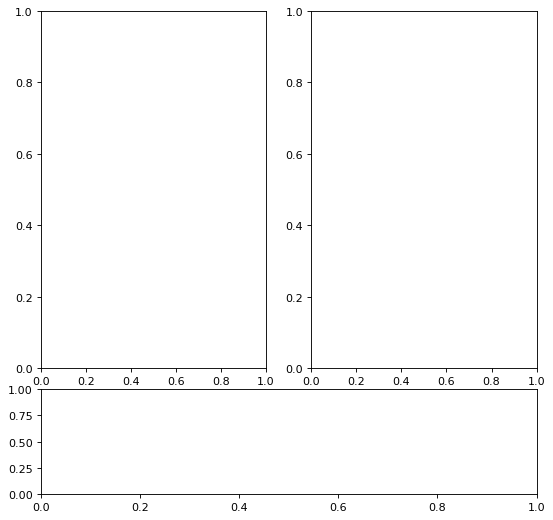

In [7]:
fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
k = 4
ax1 = plt.subplot(k,2,(1,2*k-3))
ax2 = plt.subplot(k,2,(2,2*k-2))
ax3 = plt.subplot(k,2,(2*k-1,2*k))
    
# animation function 
def animate(i): 
    x = info[i]["x"]
    y = info[i]["y"]
    arr_u = info[i]["arr_u"]
    arr_v = info[i]["arr_v"]
  
    ax1.clear()
    ax1.imshow(np.swapaxes(env.field,0,1),origin="lower")
    ax1.plot(x,y,'rx-')
    
    ax2.clear()
    ax2.imshow(np.swapaxes(env.field,0,1),origin="lower")
    ax2.quiver(np.swapaxes(arr_u,0,1),np.swapaxes(arr_v,0,1),units='xy',angles='xy',scale=1,
               width=0.1,headwidth=6)
    
    ax3.clear()
    filtered = scipy.signal.savgol_filter(lens,window_length=101, polyorder=1,)
    ax3.semilogy(filtered,'-')
    ax3.semilogy(i*every_n,filtered[i*every_n],"ro",markersize=5)

ani = animation.FuncAnimation(fig, animate,frames=int(length/every_n+1),interval=1000)

In [8]:
IPython.display.HTML(ani.to_jshtml())